# EDA 미니 프로젝트

### 전처리 목적
본 노트북은 영화 데이터에서 **관람인원수(VIEWNG_NMPR_CO)** 를 핵심 지표로 활용하기 위해, 날짜(OPN_DE) 및 관람인원수(VIEWNG_NMPR_CO)의 형식 불일치/결측/비정상 값을 정제하고 범주형 변수(DISTB_CMPNY_NM, GENRE_NM, NLTY_NM)를 분석 가능한 형태로 표준화 하는 과정을 일관된 정책으로 수행한다.

### 전처리 설계 원칙
- 안전성 우선: 원본 컬럼은 최대한 보존하고, 정제 컬럼을 별도로 생성 후 검증 뒤 반영한다.
- 정책 기반 처리: “왜 제거/대체/표준화 했는지”를 단계별로 명시해 재현성과 설명가능성을 확보한다.
- 검증 루프 포함: 정제 전/후에 비정상 값 개수와 샘플을 확인하여 품질을 보장한다.

## 1) 기본 설정 세팅

In [2]:
# (선택) 라이브러리 설치가 안 될 때만 실행
!pip install pandas matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

한글 폰트 설정 (Windows)

In [4]:
import matplotlib
import matplotlib.font_manager as fm

# Windows 기본 폰트 경로 예시 (환경에 따라 폰트 파일명은 다를 수 있음)
font_path = "C:\\Windows\\Fonts\\malgun.TTF"
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()

matplotlib.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)  # 음수 기호 깨짐 방지

## 2) 데이터셋 로드

In [5]:
movie_df = pd.read_csv("./data/merged_56_utf8.csv")
movie_df.head()

,NO,MOVIE_NM,DRCTR_NM,MAKR_NM,INCME_CMPNY_NM,DISTB_CMPNY_NM,OPN_DE,MOVIE_TY_NM,MOVIE_STLE_NM,NLTY_NM,TOT_SCRN_CO,SALES_PRICE,VIEWNG_NMPR_CO,SEOUL_SALES_PRICE,SEOUL_VIEWNG_NMPR_CO,GENRE_NM,GRAD_NM,MOVIE_SDIV_NM
0,1.0,남산의 부장들,우민호,(주)하이브미디어코프,NaN,(주)쇼박스,20200122,개봉영화,장편,한국,1659,41223596650,4750104,9851448590,1113402,드라마,15세이상관람가,일반영화
1,2.0,다만 악에서 구하소서,홍원찬,(주)하이브미디어코프,NaN,(주)씨제이이엔엠,20200805,개봉영화,장편,한국,1998,38554527990,4352669,8906277620,984042,범죄,15세이상관람가,일반영화
2,3.0,반도,연상호,(주)영화사레드피터,NaN,(주)넥스트엔터테인먼트월드(NEW),20200715,개봉영화,장편,한국,2575,33071341280,3812080,8005831840,895163,액션,15세이상관람가,일반영화
3,4.0,히트맨,최원섭,베리굿스튜디오(주),NaN,롯데컬처웍스(주)롯데엔터테인먼트,20200122,개봉영화,장편,한국,1122,20614278000,2406232,4072414720,472840,코미디,15세이상관람가,일반영화
4,5.0,테넷,크리스토퍼 놀란,NaN,워너브러더스 코리아(주),워너브러더스 코리아(주),20200826,개봉영화,장편,미국,2228,18396929850,1992214,6615682400,677442,액션,12세이상관람가,일반영화


In [6]:
print(movie_df.columns.tolist())

['NO', 'MOVIE_NM', 'DRCTR_NM', 'MAKR_NM', 'INCME_CMPNY_NM', 'DISTB_CMPNY_NM', 'OPN_DE', 'MOVIE_TY_NM', 'MOVIE_STLE_NM', 'NLTY_NM', 'TOT_SCRN_CO', 'SALES_PRICE', 'VIEWNG_NMPR_CO', 'SEOUL_SALES_PRICE', 'SEOUL_VIEWNG_NMPR_CO', 'GENRE_NM', 'GRAD_NM', 'MOVIE_SDIV_NM']


In [7]:
movie_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 12472 entries, 0 to 12471
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NO                    11877 non-null  float64
 1   MOVIE_NM              11877 non-null  str    
 2   DRCTR_NM              10125 non-null  str    
 3   MAKR_NM               5023 non-null   str    
 4   INCME_CMPNY_NM        4651 non-null   str    
 5   DISTB_CMPNY_NM        11876 non-null  str    
 6   OPN_DE                11875 non-null  str    
 7   MOVIE_TY_NM           11877 non-null  str    
 8   MOVIE_STLE_NM         11877 non-null  str    
 9   NLTY_NM               11877 non-null  str    
 10  TOT_SCRN_CO           11472 non-null  str    
 11  SALES_PRICE           5382 non-null   str    
 12  VIEWNG_NMPR_CO        10019 non-null  str    
 13  SEOUL_SALES_PRICE     8229 non-null   str    
 14  SEOUL_VIEWNG_NMPR_CO  10380 non-null  str    
 15  GENRE_NM              11842 no

## 3) 중복 영화 관객 수 누적처리 및 중복 삭제

In [8]:
movie_df.describe(include="all")
# 1️⃣ 컬럼 공백 제거
movie_df.columns = movie_df.columns.str.strip()

# 2️⃣ 관객수 숫자 변환
movie_df['VIEWNG_NMPR_CO'] = (
    movie_df['VIEWNG_NMPR_CO']
    .astype(str)
    .str.replace(',', '', regex=False)
)

movie_df['VIEWNG_NMPR_CO'] = pd.to_numeric(
    movie_df['VIEWNG_NMPR_CO'],
    errors='coerce'
)

# 3️⃣ 영화별 누적 관객수 집계
result_df = movie_df.groupby(
    ['MOVIE_NM', 'DRCTR_NM', 'OPN_DE'],
    as_index=False
).agg({
    'VIEWNG_NMPR_CO': 'sum',        # 관객수 합산
    'DISTB_CMPNY_NM': 'first',      # 배급사 첫 값
    'GENRE_NM': 'first',
    'NLTY_NM': 'first',
    'GRAD_NM': 'first'
})
# 4️⃣ 확인
print(result_df.head())
print("최종 행 개수:", len(result_df))

  MOVIE_NM          DRCTR_NM      OPN_DE  VIEWNG_NMPR_CO       DISTB_CMPNY_NM  \
0    #살아있다               조일형    20200624       1903703.0    롯데컬처웍스(주)롯데엔터테인먼트   
1   #아이엠히어            에릭 라티고    20210114         16404.0  (주)넥스트엔터테인먼트월드(NEW)   
2    #위왓치유  바르보라 차르포바,비트 클루삭    2021-06-            14.0                   찬란   
3    #위왓치유  바르보라 차르포바,비트 클루삭  20210603.0             0.0                   찬란   
4    #해시태그               이상식    2022-06-           173.0          (주)더존크리에이티브   

  GENRE_NM NLTY_NM   GRAD_NM  
0      드라마      한국  15세이상관람가  
1   멜로/로맨스     프랑스  12세이상관람가  
2    다큐멘터리      기타   청소년관람불가  
3    다큐멘터리      기타   청소년관람불가  
4       공연      한국  12세이상관람가  
최종 행 개수: 6986


## 4) 데이터 전처리 2단계: 컬럼별 정리
본 단계에서는 전처리 대상 컬럼을 (1) 핵심 수치형 2개와 (2) 범주형 3개로 구분하고, 각 컬럼별로 데이터 품질 이슈 → 처리 정책 → 기대 효과를 명시한다.
목표는 “분석/시각화/모델링에 바로 투입 가능한 형태”로 형식 표준화 + 결측/비정상 관리 + 범주 축약을 일관되게 수행하는 것이다.

### 4-1) 필요한 컬럼만 선택
선택 기준
- 타깃(관람인원수): VIEWNG_NMPR_CO
- 설명변수(범주): DISTB_CMPNY_NM(배급사), GENRE_NM(장르), NLTY_NM(국적)
- 시간변수(개봉일): OPN_DE

In [9]:
use_cols = ["VIEWNG_NMPR_CO", "DISTB_CMPNY_NM", "GENRE_NM", "NLTY_NM", "OPN_DE", 'GRAD_NM']
result_df = result_df[use_cols].copy()
result_df.head()

,VIEWNG_NMPR_CO,DISTB_CMPNY_NM,GENRE_NM,NLTY_NM,OPN_DE,GRAD_NM
0,1903703.0,롯데컬처웍스(주)롯데엔터테인먼트,드라마,한국,20200624,15세이상관람가
1,16404.0,(주)넥스트엔터테인먼트월드(NEW),멜로/로맨스,프랑스,20210114,12세이상관람가
2,14.0,찬란,다큐멘터리,기타,2021-06-,청소년관람불가
3,0.0,찬란,다큐멘터리,기타,20210603.0,청소년관람불가
4,173.0,(주)더존크리에이티브,공연,한국,2022-06-,12세이상관람가


In [10]:
result_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6986 entries, 0 to 6985
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   VIEWNG_NMPR_CO  6986 non-null   float64
 1   DISTB_CMPNY_NM  6985 non-null   str    
 2   GENRE_NM        6969 non-null   str    
 3   NLTY_NM         6986 non-null   str    
 4   OPN_DE          6986 non-null   str    
 5   GRAD_NM         6986 non-null   str    
dtypes: float64(1), str(5)
memory usage: 327.6 KB


### OPN_DE 컬럼

#### 컬럼 이슈 진단
**목표**

OPN_DE를 **분석 가능한 날짜형(datetime)** 으로 변환하기 위한 사전 점검.

관측된 이슈 유형(예시)

- YYYYMMDD.0 형태: 로딩 과정에서 float 흔적이 문자열로 남은 케이스
- NaN: 개봉일 정보 누락
- YYYY-MM- 형태: 연-월까지만 있고 일(day)이 비어있는 케이스
- 기타: 하이픈/공백/문자 혼입 등 비정형 케이스

1. 결측치(NaN) 개수 확인

In [11]:
nan_count = result_df["OPN_DE"].isna().sum()
print("NaN count:", nan_count)

NaN count: 0


2. 8자리(YYYYMMDD)가 아닌 값 찾기
- 정책상 최종 목표 포맷은 YYYYMMDD(8자리 숫자)로 정규화
- NaN 포함 시 문자열 함수가 예외/의도치 않은 결과를 만들 수 있으므로 astype(str)로 안전 처리 후 점검

In [12]:
mask_not_yyyymmdd = ~result_df["OPN_DE"].astype(str).str.match(r"^\d{8}$")
result_df.loc[mask_not_yyyymmdd, "OPN_DE"].head(10)

2       2021-06-
3     20210603.0
4       2022-06-
6       2021-09-
11      2021-07-
12      2021-09-
19      2022-04-
21      2022-04-
29      2022-08-
33      2022-06-
Name: OPN_DE, dtype: str

In [13]:
print("Not YYYYMMDD count:", mask_not_yyyymmdd.sum())

Not YYYYMMDD count: 2898


3. .0가 포함된 값 확인

In [14]:
mask_dot0 = result_df["OPN_DE"].astype(str).str.contains(r".0", regex=True)
result_df.loc[mask_dot0, "OPN_DE"].head(20)

print(".0 포함 count:", mask_dot0.sum())

.0 포함 count: 6915


#### 정제 함수 정의
**처리 정책(Policy)**
1. OPN_DE 결측치 행은 제거
- 기준: 개봉일은 시계열/연도별 집계에서 핵심 키이며, 결측이 소수인 경우(예: 3건 수준) 데이터 손실 영향이 작다.
2. YYYYMMDD.0 → YYYYMMDD로 정리
3. YYYY-MM- → 날짜(day)가 없으므로 **해당 월의 1일(01)**을 부여하여 YYYYMM01로 정규화
- 기준: “월 단위 정보라도 살릴 가치가 있다”는 보수적 보정. (필요 시 이후 단계에서 월 단위 분석 가능)
4. 그 외 비정형 입력은 숫자만 추출 후 길이에 따라 day를 보정(방어적 처리)
- YYYYMM(6자리) → YYYYMM01
- YYYY(4자리) → YYYY0101
5. 최종적으로 8자리만 유지(과도한 길이/잡문자 유입 방지)
**반환**
- OPN_DE를 **문자열 'YYYYMMDD'**로 정제한 DataFrame

In [15]:
def clean_opn_de_to_datetime(df: pd.DataFrame, col: str = "OPN_DE") -> pd.DataFrame:
    """
    개봉일자(OPN_DE)를 정규화한 뒤 datetime64[ns]로 변환한다.

    처리 정책
    - 결측치 제거(dropna)
    - 'YYYY-MM-' -> 'YYYY-MM-01'로 보정
    - 'YYYYMMDD.0' -> '.0' 제거
    - 숫자만 남기고 길이 보정:
        * YYYYMM(6) -> YYYYMM01
        * YYYY(4)  -> YYYY0101
      이후 8자리로 절단
    - pd.to_datetime(format='%Y%m%d', errors='coerce')로 변환
    - 변환 실패(NaT) 제거

    Returns
    - col: datetime64[ns]
    """
    df = df.copy()

    # 1) 결측치 제거
    df = df.dropna(subset=[col])

    # 2) 문자열 정리
    s = df[col].astype(str).str.strip()

    # 3) 'YYYY-MM-' -> 'YYYY-MM-01'
    s = s.str.replace(r"^(\d{4})-(\d{2})-$", r"\1-\2-01", regex=True)

    # 4) '.0' 제거
    s = s.str.replace(r"\.0$", "", regex=True)

    # 5) 숫자만 남기기
    s = s.str.replace(r"\D", "", regex=True)

    # 6) 길이 보정(방어적)
    mask_6 = s.str.len().eq(6)
    s.loc[mask_6] = s.loc[mask_6] + "01"

    mask_4 = s.str.len().eq(4)
    s.loc[mask_4] = s.loc[mask_4] + "0101"

    # 7) 8자리로 제한
    s = s.str[:8]

    # 8) datetime 변환
    dt = pd.to_datetime(s, format="%Y%m%d", errors="coerce")
    df[col] = dt

    # 9) NaT 제거
    df = df.dropna(subset=[col])

    return df

In [16]:
result_df = clean_opn_de_to_datetime(result_df, col="OPN_DE")
result_df["OPN_DE"].head(10)

0   2020-06-24
1   2021-01-14
2   2021-06-01
3   2021-06-03
4   2022-06-01
5   2025-01-08
6   2021-09-01
7   2024-08-15
8   2020-12-24
9   2023-01-12
Name: OPN_DE, dtype: datetime64[us]

In [17]:
result_df.info()

<class 'pandas.DataFrame'>
Index: 6902 entries, 0 to 6985
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  6902 non-null   float64       
 1   DISTB_CMPNY_NM  6901 non-null   str           
 2   GENRE_NM        6885 non-null   str           
 3   NLTY_NM         6902 non-null   str           
 4   OPN_DE          6902 non-null   datetime64[us]
 5   GRAD_NM         6902 non-null   str           
dtypes: datetime64[us](1), float64(1), str(4)
memory usage: 377.5 KB


#### 최종 검증 및 정리
**기준/이유**
- datetime 변환 후에도 NaT가 남아있다면 “정제 정책으로 커버 못한 입력”이 존재하는 것이므로 샘플을 확인한다.
- 분석에서 날짜가 필요한 경우, NaT는 제거하여 시간축 기반 분석의 일관성을 확보한다.

In [18]:
print("NaT count after conversion:", result_df["OPN_DE"].isna().sum())

NaT count after conversion: 0


In [19]:
result_df.loc[movie_df["OPN_DE"].isna(), ["OPN_DE"]].head()

,OPN_DE
3339,2023-11-22
6341,2022-06-22
6342,2020-02-14
6343,2020-08-20
6559,2023-11-15


In [20]:
result_df.info()

<class 'pandas.DataFrame'>
Index: 6902 entries, 0 to 6985
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  6902 non-null   float64       
 1   DISTB_CMPNY_NM  6901 non-null   str           
 2   GENRE_NM        6885 non-null   str           
 3   NLTY_NM         6902 non-null   str           
 4   OPN_DE          6902 non-null   datetime64[us]
 5   GRAD_NM         6902 non-null   str           
dtypes: datetime64[us](1), float64(1), str(4)
memory usage: 377.5 KB


### VIEWNG_NMPR_CO 컬럼

#### 결측치 처리
**기준/이유**
- 본 프로젝트의 핵심 지표는 관람인원수이므로, 값이 없는 행은 모델링/집계/시각화에서 활용 불가하다.
- 따라서 VIEWNG_NMPR_CO가 결측인 행은 제거한다.

In [21]:
result_df = result_df.dropna(subset=["VIEWNG_NMPR_CO"])
result_df.info()

<class 'pandas.DataFrame'>
Index: 6902 entries, 0 to 6985
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  6902 non-null   float64       
 1   DISTB_CMPNY_NM  6901 non-null   str           
 2   GENRE_NM        6885 non-null   str           
 3   NLTY_NM         6902 non-null   str           
 4   OPN_DE          6902 non-null   datetime64[us]
 5   GRAD_NM         6902 non-null   str           
dtypes: datetime64[us](1), float64(1), str(4)
memory usage: 377.5 KB


#### 컬럼 이슈 진단
**관측된 이슈**
- 문자열 타입으로 들어와 있음
- 값이 다음 패턴으로 혼재할 수 있음
    - 정수 문자열: "1234"
    - 소수점 흔적: "1234.0"
    - 콤마 포함: "1,234"

**목표**
전처리 후 VIEWNG_NMPR_CO를 **정수형(int64)**으로 변환하여 수치 분석 가능하게 만든다.

정수만 있는 경우가 아니라면 표시 (콤마/소수점/기타 문자 포함 탐지)

In [22]:
mask_not_int = ~result_df["VIEWNG_NMPR_CO"].astype(str).str.match(r"^\d+$")
result_df.loc[mask_not_int, "VIEWNG_NMPR_CO"].head(20)

0     1903703.0
1       16404.0
2          14.0
3           0.0
4         173.0
5        5294.0
6           6.0
7       59525.0
8       17089.0
9           0.0
10        782.0
11          1.0
12          1.0
13        286.0
14         60.0
15         60.0
16         60.0
17         60.0
18        169.0
19          1.0
Name: VIEWNG_NMPR_CO, dtype: float64

In [23]:
print("Not pure integer string count:", mask_not_int.sum())

Not pure integer string count: 6902


허용 패턴: '1234' 또는 '1234.0' (콤마는 제거 후 처리 예정)

In [24]:
mask_not_valid = ~result_df["VIEWNG_NMPR_CO"].astype(str).str.replace(",", "", regex=False).str.match(r"^\d+(.0)?$")
result_df.loc[mask_not_valid, "VIEWNG_NMPR_CO"].head(20)

Series([], Name: VIEWNG_NMPR_CO, dtype: float64)

#### 정제 함수 정의
**처리 정책(Policy)**
1. 콤마 제거 후 문자열 통일
2. pd.to_numeric(..., errors='coerce')로 숫자 변환
    - 변환 실패 값은 NaN으로 표준화 (이후 제거)
3. 소수점 흔적(.0)이 포함된 값도 숫자로 흡수한 뒤 정수형으로 캐스팅
4. 최종적으로 결측/비정상 값은 제거하여 분석 품질 확보

주의: 정수형 변환은 astype("int64")로 고정하는 것이 가장 명확하다.

In [25]:
def clean_viewng_nmpr_co_to_int(df: pd.DataFrame, col: str = "VIEWNG_NMPR_CO") -> pd.DataFrame:
    """
    관람인원수(VIEWNG_NMPR_CO)를 정수형(int64)으로 정제한다.

    처리 정책
    - 결측치 제거(dropna)
    - 콤마 제거 후 숫자 변환(pd.to_numeric, errors='coerce')
    - 변환 실패는 NaN 처리 후 제거
    - 최종 int64로 캐스팅

    Returns
    - col: int64
    """
    df = df.copy()

    # 1) 결측치 제거
    df = df.dropna(subset=[col])

    # 2) 문자열 통일 + 콤마 제거
    s = df[col].astype(str).str.replace(",", "", regex=False).str.strip()

    # 3) 숫자 변환 (불가 -> NaN)
    num = pd.to_numeric(s, errors="coerce")
    df[col] = num

    # 4) 변환 실패 제거
    df = df.dropna(subset=[col])

    # 5) 정수형 변환
    df[col] = df[col].astype("int64")

    return df

In [26]:
result_df = clean_viewng_nmpr_co_to_int(result_df, col="VIEWNG_NMPR_CO")

In [27]:
print(result_df["VIEWNG_NMPR_CO"].dtype)
result_df["VIEWNG_NMPR_CO"].head()

int64


0    1903703
1      16404
2         14
3          0
4        173
Name: VIEWNG_NMPR_CO, dtype: int64

#### 최종 검증 및 정리
**기준/이유**
- 전처리 후에도 NaN이 남아있지 않은지
- 0 값이 과도하게 존재하지 않는지(수집 오류/의미 없는 레코드 가능성)를 확인해 데이터 품질 리스크를 사전에 식별한다.

In [28]:
null_count = result_df["VIEWNG_NMPR_CO"].isna().sum()
zero_count = (result_df["VIEWNG_NMPR_CO"] == 0).sum()

print(f"1) NaN(결측치) 개수: {null_count}개")
print(f"2) 0 값 데이터 개수 : {zero_count}개")
print(f"3) 전체 데이터 개수 : {len(movie_df)}개")

1) NaN(결측치) 개수: 0개
2) 0 값 데이터 개수 : 435개
3) 전체 데이터 개수 : 12472개


### 범주형 변수 정리 개요
이제 남은 컬럼은 범주형(카테고리) 변수 3개이며, 목표는 다음과 같다.
- DISTB_CMPNY_NM(배급사): 표기 흔들림/공동배급/법인수식어 등을 정리하여 표준 배급사명으로 통합
- GENRE_NM(장르): 결측은 분석 누락 방지를 위해 **'미상'**으로 통일
- NLTY_NM(국적): 필요 시 '한국/미국/일본/기타' 등으로 top-N + 기타 전략 적용 가능

### DISTB_CMPNY_NM 컬럼

#### 컬럼 이슈 진단
**기준/이유**
- 배급사는 표기 변형이 많다(띄어쓰기/법인명/영문/한글/계열사).
- 먼저 빈도 상위와 키워드 매칭을 통해 “통합 규칙이 필요한 집단”을 파악한다.

In [29]:
print("--- 빈도수 상위 30개 배급사 명칭 ---")
print(result_df["DISTB_CMPNY_NM"].value_counts().head(30))

keywords = ["씨제이", "CJ", "롯데", "넥스트", "NEW", "쇼박스", "플러스엠", "워너", "디즈니", "유니버설"]

print("\n--- 주요 키워드 포함 명칭 리스트(샘플) ---")
for kw in keywords:
    matches = result_df[result_df["DISTB_CMPNY_NM"].astype(str).str.contains(kw, na=False, case=False)][
        "DISTB_CMPNY_NM"].unique()
print(f"[{kw}] 관련 명칭들 ({len(matches)}종류) 샘플:")
print(matches[:5])
print("-" * 40)

--- 빈도수 상위 30개 배급사 명칭 ---
DISTB_CMPNY_NM
(주)영진크리에이티브            1066
(주)영화사가을                419
(주)가온콘텐츠                230
(주)샤이커뮤니케이션즈            195
(주)라온컴퍼니플러스             155
유니버설픽쳐스인터내셔널 코리아(유)     105
케이엘 픽쳐스                 101
스마일컨텐츠                   98
(주)영화사히트                 88
(주)씨맥스커뮤니케이션즈            88
월트디즈니컴퍼니코리아 유한책임회사       85
롯데컬처웍스(주)롯데엔터테인먼트        82
주식회사 루믹스미디어              80
(주)컨텐츠 빌리지               77
(주)디스테이션                 76
(주)넥스트엔터테인먼트월드(NEW)      70
워너브러더스 코리아(주)            65
(주)코빈커뮤니케이션즈             65
(주)씨제이이엔엠                64
(주)영화사 진진                63
씨제이 씨지브이(CJ CGV)(주)      62
주식회사 플릭스코                62
(주)미디어캐슬                 62
(주)도키엔터테인먼트              61
(주)엣나인필름                 60
(주)담화                    58
(주)픽쳐레스크                 57
(주)팝엔터테인먼트               56
(주)케이알씨지                 56
(주)트리플픽쳐스                55
Name: count, dtype: int64

--- 주요 키워드 포함 명칭 리스트(샘플) ---
[유니버설] 관련 명칭들 (1종류) 샘플:
<StringArray>
['유니버설픽쳐스인터내셔널 코리아(유)']
L

#### 결측치 처리
**기준/이유**
- NaN을 그대로 두면 장르별 집계/시각화에서 자동 제외되어 분석 대상이 의도치 않게 줄어든다.
- NaN 뿐 아니라 '', ' ' 같은 빈 문자열도 실질적으로 결측이다.
- 범주형 전처리 전에 결측 규모를 파악하고, 정책(제거 vs 대체)을 결정한다.
- 따라서 결측치는 **'미상'** 으로 대체하여 분석 과정에서 하나의 명시적 범주로 취급한다.

In [30]:
nan_count = result_df["DISTB_CMPNY_NM"].isna().sum()
empty_str_count = (result_df["DISTB_CMPNY_NM"].astype(str).str.strip() == "").sum()

print("NaN count:", nan_count)
print("Empty/blank string count:", empty_str_count)

NaN count: 1
Empty/blank string count: 0


In [31]:
result_df

,VIEWNG_NMPR_CO,DISTB_CMPNY_NM,GENRE_NM,NLTY_NM,OPN_DE,GRAD_NM
0,1903703,롯데컬처웍스(주)롯데엔터테인먼트,드라마,한국,2020-06-24,15세이상관람가
1,16404,(주)넥스트엔터테인먼트월드(NEW),멜로/로맨스,프랑스,2021-01-14,12세이상관람가
2,14,찬란,다큐멘터리,기타,2021-06-01,청소년관람불가
3,0,찬란,다큐멘터리,기타,2021-06-03,청소년관람불가
4,173,(주)더존크리에이티브,공연,한국,2022-06-01,12세이상관람가
...,...,...,...,...,...,...
6981,20,(주)나우콘텐츠,멜로/로맨스,한국,2021-03-18,청소년관람불가
6982,5184,(주)엣나인필름,드라마,한국,2024-12-18,12세이상관람가
6983,6246,(주)티캐스트,다큐멘터리,영국,2024-05-01,15세이상관람가
6984,0,"(주)레드아이스 엔터테인먼트,(주)제이앤씨미디어그룹",SF,미국,2023-09-20,15세이상관람가


In [32]:
result_df['DISTB_CMPNY_NM'] = result_df['DISTB_CMPNY_NM'].fillna('미상')

#### 배급사 1차 정제: 공동배급 분리 + 법인 수식어 제거
**처리 정책(Policy)**
1. 결측은 일단 빈 문자열로 채운 뒤 처리 (문자열 메서드 안정성)
2. 공동 배급 표기(콤마 연결)는 첫 번째 배급사를 대표값으로 사용
    - 기준: 단순화 목적(EDA)이며, 공동배급을 모두 반영하려면 별도 파싱/다중 라벨링이 필요
3. (주), 주식회사 등 법인 수식어 및 (NEW)/NEW 등의 불필요 토큰 제거
4. 결과는 DIST_CLEAN 정제 컬럼으로 생성 (원본 보존)

In [33]:
def clean_distb_cmpny_nm(df: pd.DataFrame, col: str = "DISTB_CMPNY_NM") -> pd.DataFrame:
    """
    배급사명(DISTB_CMPNY_NM)을 1차 정제하여 'DIST_CLEAN' 컬럼을 생성한다.

    처리 정책
    - NaN -> ''로 치환(문자열 처리 안정성)
    - 콤마로 연결된 공동배급 표기에서 첫 번째 값만 대표값으로 사용
    - 법인 수식어 제거: (주), 주식회사, (유), 유한책임회사
    - 불필요 토큰 제거: (NEW), NEW
    - strip()으로 공백 정리

    Returns
    - DIST_CLEAN: 정제된 배급사명(문자열)
    """
    df = df.copy()

    s = df[col].fillna("").astype(str)

    # 공동배급: 첫 번째만 사용
    s = s.str.split(",").str[0]

    # 토큰 제거 및 공백 정리
    s = (
        s.str.replace(r"\(NEW\)|NEW", "", regex=True, case=False)
         .str.replace(r"\(주\)|주식회사|\(유\)|유한책임회사", "", regex=True)
         .str.strip()
    )

    df["DIST_CLEAN"] = s
    return df

In [34]:
result_df = clean_distb_cmpny_nm(result_df)

In [35]:
result_df["DIST_CLEAN"].unique()[:20]

array(['롯데컬처웍스롯데엔터테인먼트', '넥스트엔터테인먼트월드', '찬란', '더존크리에이티브', '씨제이포디플렉스',
       '유니버설픽쳐스인터내셔널 코리아', '박수엔터테인먼트', '팝엔터테인먼트', '그노스', '알토미디어',
       '스마일컨텐츠', '마노엔터테인먼트', '케이엘 픽쳐스', '라임필름', '루믹스미디어', '스마일이엔티',
       '영화특별시에스엠씨', '조이앤시네마', '그린나래미디어', '제이앤씨미디어그룹'], dtype=object)

#### 배급사 표준화(통합) 함수: 그룹 단위 매핑
**기준/이유**
- EDA/시각화에서 배급사 카테고리가 과도하게 분산되면 인사이트 도출이 어려워진다.
- 따라서 대표 그룹(예: CJ ENM/워너/디즈니 등)은 규칙 기반으로 표준 라벨로 통합한다.
- 결과는 DIST_MERGED 컬럼에 반영한다.

In [36]:
def merge_dist_name(name) -> str:
    """
    정제된 배급사명(DIST_CLEAN)을 표준 라벨로 통합한다(규칙 기반).

    Parameters
    - name: 단일 배급사명(문자열/NaN 가능)

    Returns
    - 표준화된 배급사명(문자열)
    """
    if pd.isna(name) or not str(name).strip():
        return name

    s = str(name).strip()
    s = " ".join(s.split())  # 연속 공백 정리

    # CJ ENM
    if ("씨제이이엔엠" in s) or ("CJ ENM" in s) or ("씨제이" in s and "이엔엠" in s):
        return "CJ ENM"

    # CJ CGV
    if ("CGV" in s) or ("씨지브이" in s):
        return "CJ CGV"

    # CJ 4DPLEX
    if ("포디플렉스" in s) or ("4DPLEX" in s):
        return "CJ 4DPLEX"

    # 롯데
    if "롯데컬처웍스" in s:
        return "롯데컬처웍스"

    # 플러스엠
    if ("메가박스중앙" in s) or ("플러스엠" in s):
        return "플러스엠"

    # 디즈니 / 유니버설 / 소니 / 워너
    if ("월트디즈니" in s) or ("디즈니컴퍼니코리아" in s):
        return "월트디즈니"

    if "유니버설픽쳐스" in s:
        return "유니버설픽쳐스"

    if "소니픽쳐스" in s:
        return "소니픽쳐스"

    if "워너브러더스" in s:
        return "워너브러더스"

    # 띄어쓰기 차이 방어
    compact = s.replace(" ", "")

    if compact in ["영화사빅", "영화사진진"]:
        return compact

    if "더쿱" in compact:
        return "더쿱"
    if "무비다이브" in compact:
        return "무비다이브"
    if "모쿠슈라" in compact:
        return "모쿠슈라"

    return s

In [37]:
result_df["DIST_MERGED"] = result_df["DIST_CLEAN"].apply(merge_dist_name)
result_df[["DISTB_CMPNY_NM", "DIST_CLEAN", "DIST_MERGED"]].head()

,DISTB_CMPNY_NM,DIST_CLEAN,DIST_MERGED
0,롯데컬처웍스(주)롯데엔터테인먼트,롯데컬처웍스롯데엔터테인먼트,롯데컬처웍스
1,(주)넥스트엔터테인먼트월드(NEW),넥스트엔터테인먼트월드,넥스트엔터테인먼트월드
2,찬란,찬란,찬란
3,찬란,찬란,찬란
4,(주)더존크리에이티브,더존크리에이티브,더존크리에이티브


#### 배급사 top-N 전략: 상위 30 + 기타(Other)
**기준/이유**
- 배급사 종류가 너무 많으면 시각화/비교가 어려워진다.
- 따라서 상위 30개 배급사는 유지하고, 나머지는 **'기타'**로 묶어 EDA의 가독성을 높인다.
- 결과 컬럼: DIST_TOP30

In [38]:
dist_count = result_df["DIST_MERGED"].value_counts()
top30_dist = dist_count.head(30).index.tolist()
print(top30_dist)

['영진크리에이티브', '영화사가을', '가온콘텐츠', '샤이커뮤니케이션즈', '라온컴퍼니플러스', '유니버설픽쳐스', 'CJ CGV', '케이엘 픽쳐스', '스마일컨텐츠', '롯데컬처웍스', '영화사히트', '씨맥스커뮤니케이션즈', '월트디즈니', '디스테이션', '루믹스미디어', '컨텐츠 빌리지', '넥스트엔터테인먼트월드', '영화사진진', '플러스엠', '엣나인필름', 'CJ ENM', '워너브러더스', '코빈커뮤니케이션즈', '제이앤씨미디어그룹', '미디어캐슬', '플릭스코', '도키엔터테인먼트', '와이드 릴리즈', '찬란', '팝엔터테인먼트']


In [39]:
result_df["DIST_TOP30"] = result_df["DIST_MERGED"].apply(lambda x: x if x in top30_dist else "기타")
result_df["DIST_TOP30"].value_counts()

DIST_TOP30
기타             2923
영진크리에이티브       1067
영화사가을           419
가온콘텐츠           230
샤이커뮤니케이션즈       195
라온컴퍼니플러스        155
유니버설픽쳐스         105
CJ CGV          105
케이엘 픽쳐스         101
스마일컨텐츠           98
롯데컬처웍스           96
영화사히트            88
씨맥스커뮤니케이션즈       88
월트디즈니            85
디스테이션            81
루믹스미디어           80
컨텐츠 빌리지          77
넥스트엔터테인먼트월드      76
영화사진진            74
플러스엠             71
엣나인필름            66
CJ ENM           66
워너브러더스           65
코빈커뮤니케이션즈        65
제이앤씨미디어그룹        64
미디어캐슬            63
플릭스코             62
도키엔터테인먼트         61
와이드 릴리즈          60
찬란               58
팝엔터테인먼트          58
Name: count, dtype: int64

In [40]:
result_df.info()

<class 'pandas.DataFrame'>
Index: 6902 entries, 0 to 6985
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  6902 non-null   int64         
 1   DISTB_CMPNY_NM  6902 non-null   str           
 2   GENRE_NM        6885 non-null   str           
 3   NLTY_NM         6902 non-null   str           
 4   OPN_DE          6902 non-null   datetime64[us]
 5   GRAD_NM         6902 non-null   str           
 6   DIST_CLEAN      6902 non-null   object        
 7   DIST_MERGED     6902 non-null   str           
 8   DIST_TOP30      6902 non-null   str           
dtypes: datetime64[us](1), int64(1), object(1), str(6)
memory usage: 539.2+ KB


### GENRE_NM 컬럼

#### 결측치 처리
**처리 기준(Policy)**
- GENRE_NM 결측은 “장르가 없다”가 아니라 “장르 정보가 누락/미제공”일 가능성이 크다.
- NaN을 그대로 두면 장르별 집계/시각화에서 자동 제외되어 분석 대상이 의도치 않게 줄어든다.
- 따라서 결측치는 **'미상'** 으로 대체하여 분석 과정에서 하나의 명시적 범주로 취급한다.

In [41]:
result_df['GENRE_NM'].isna().sum()

np.int64(17)

In [42]:
result_df["GENRE_NM"] = result_df["GENRE_NM"].fillna("미상")
result_df["GENRE_NM"].value_counts().head(30)

GENRE_NM
멜로/로맨스      1975
성인물(에로)     1387
드라마         1217
애니메이션        430
액션           398
다큐멘터리        322
코미디          201
공포(호러)       181
공연           136
스릴러          128
범죄           111
기타            82
미스터리          79
SF            54
판타지           41
어드벤처          33
뮤지컬           32
전쟁            30
가족            28
미상            17
사극            14
서부극(웨스턴)       6
Name: count, dtype: int64

In [43]:
result_df.info()

<class 'pandas.DataFrame'>
Index: 6902 entries, 0 to 6985
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  6902 non-null   int64         
 1   DISTB_CMPNY_NM  6902 non-null   str           
 2   GENRE_NM        6902 non-null   str           
 3   NLTY_NM         6902 non-null   str           
 4   OPN_DE          6902 non-null   datetime64[us]
 5   GRAD_NM         6902 non-null   str           
 6   DIST_CLEAN      6902 non-null   object        
 7   DIST_MERGED     6902 non-null   str           
 8   DIST_TOP30      6902 non-null   str           
dtypes: datetime64[us](1), int64(1), object(1), str(6)
memory usage: 539.2+ KB


### NLTY_NM 컬럼

#### 기본 점검

In [44]:
result_df["NLTY_NM"].isna().sum()

np.int64(0)

In [45]:
result_df["NLTY_NM"].unique()

<StringArray>
[   '한국',   '프랑스',    '기타',    '미국',    '영국',    '호주',   '헝가리',    '일본',
    '독일',    '중국',  '이탈리아',   '덴마크',   '러시아',   '스웨덴',    '홍콩',   '스페인',
  '포르투갈',   '캐나다',  '네덜란드',  '아일랜드',    '대만',  '뉴질랜드',    '이란',   '폴란드',
 '우크라이나',   '브라질',    '인도',   '스위스', '오스트리아',   '벨기에',   '베트남',  '루마니아',
  '노르웨이',   '필리핀',   '멕시코',   '핀란드',    '몽고',  '불가리아',    '태국',   '모로코',
    '페루', '아르헨티나', '카자흐스탄',    '칠레']
Length: 44, dtype: str

In [46]:
result_df["NLTY_NM"].value_counts()

NLTY_NM
한국       3414
일본       1912
미국        786
프랑스       161
영국        123
중국         81
기타         63
독일         55
이탈리아       41
캐나다        37
러시아        33
스페인        28
홍콩         24
호주         21
대만         15
헝가리        14
노르웨이       13
네덜란드        9
덴마크         8
폴란드         8
벨기에         8
아일랜드        6
핀란드         4
우크라이나       3
인도          3
오스트리아       3
필리핀         3
태국          3
브라질         2
스위스         2
베트남         2
멕시코         2
페루          2
아르헨티나       2
칠레          2
스웨덴         1
포르투갈        1
뉴질랜드        1
이란          1
루마니아        1
몽고          1
불가리아        1
모로코         1
카자흐스탄       1
Name: count, dtype: int64

## 5) 최종 데이터 프레임

In [47]:
result_df

,VIEWNG_NMPR_CO,DISTB_CMPNY_NM,GENRE_NM,NLTY_NM,OPN_DE,GRAD_NM,DIST_CLEAN,DIST_MERGED,DIST_TOP30
0,1903703,롯데컬처웍스(주)롯데엔터테인먼트,드라마,한국,2020-06-24,15세이상관람가,롯데컬처웍스롯데엔터테인먼트,롯데컬처웍스,롯데컬처웍스
1,16404,(주)넥스트엔터테인먼트월드(NEW),멜로/로맨스,프랑스,2021-01-14,12세이상관람가,넥스트엔터테인먼트월드,넥스트엔터테인먼트월드,넥스트엔터테인먼트월드
2,14,찬란,다큐멘터리,기타,2021-06-01,청소년관람불가,찬란,찬란,찬란
3,0,찬란,다큐멘터리,기타,2021-06-03,청소년관람불가,찬란,찬란,찬란
4,173,(주)더존크리에이티브,공연,한국,2022-06-01,12세이상관람가,더존크리에이티브,더존크리에이티브,기타
...,...,...,...,...,...,...,...,...,...
6981,20,(주)나우콘텐츠,멜로/로맨스,한국,2021-03-18,청소년관람불가,나우콘텐츠,나우콘텐츠,기타
6982,5184,(주)엣나인필름,드라마,한국,2024-12-18,12세이상관람가,엣나인필름,엣나인필름,엣나인필름
6983,6246,(주)티캐스트,다큐멘터리,영국,2024-05-01,15세이상관람가,티캐스트,티캐스트,기타
6984,0,"(주)레드아이스 엔터테인먼트,(주)제이앤씨미디어그룹",SF,미국,2023-09-20,15세이상관람가,레드아이스 엔터테인먼트,레드아이스 엔터테인먼트,기타


In [48]:
result_df.info()

<class 'pandas.DataFrame'>
Index: 6902 entries, 0 to 6985
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  6902 non-null   int64         
 1   DISTB_CMPNY_NM  6902 non-null   str           
 2   GENRE_NM        6902 non-null   str           
 3   NLTY_NM         6902 non-null   str           
 4   OPN_DE          6902 non-null   datetime64[us]
 5   GRAD_NM         6902 non-null   str           
 6   DIST_CLEAN      6902 non-null   object        
 7   DIST_MERGED     6902 non-null   str           
 8   DIST_TOP30      6902 non-null   str           
dtypes: datetime64[us](1), int64(1), object(1), str(6)
memory usage: 539.2+ KB


## 1_Grade

In [49]:
result_df['GRAD_NM'].value_counts().sort_index()

GRAD_NM
12세관람가                1
12세이상관람가           1102
15세관람가                3
15세이상관람가           1244
연소자관람불가,청소년관람불가       1
전체관람가               721
청소년관람불가            3830
Name: count, dtype: int64

## 1.1_관람등급 통일 (영화진흥위원회 기준)

In [50]:
# 공식 등급 명칭 문자열 정리 (영화진흥위원회 기준)
result_df['GRAD_NM'] = (
    result_df['GRAD_NM']
    .astype(str)
    .str.replace(' ', '', regex=False)
    .str.strip()
)

# 등급 통합 함수
def standardize_rating(x):
    if '청소년' in x or '연소자' in x:
        return '청소년관람불가'
    elif '12' in x:
        return '12세이상관람가'
    elif '15' in x:
        return '15세이상관람가'
    elif '전체' in x:
        return '전체관람가'
    else:
        return '기타'

result_df['GRAD_NM'] = result_df['GRAD_NM'].apply(standardize_rating)

# 순서 지정 (보고서용 정렬)
rating_order = [
    '전체관람가',
    '12세이상관람가',
    '15세이상관람가',
    '청소년관람불가'
]

result_df['GRAD_NM'] = pd.Categorical(
    result_df['GRAD_NM'],
    categories=rating_order,
    ordered=True)

In [51]:
result_df['GRAD_NM'].value_counts().sort_index()

GRAD_NM
전체관람가        721
12세이상관람가    1103
15세이상관람가    1247
청소년관람불가     3831
Name: count, dtype: int64

## 1.2 관람등급 도넛그래프

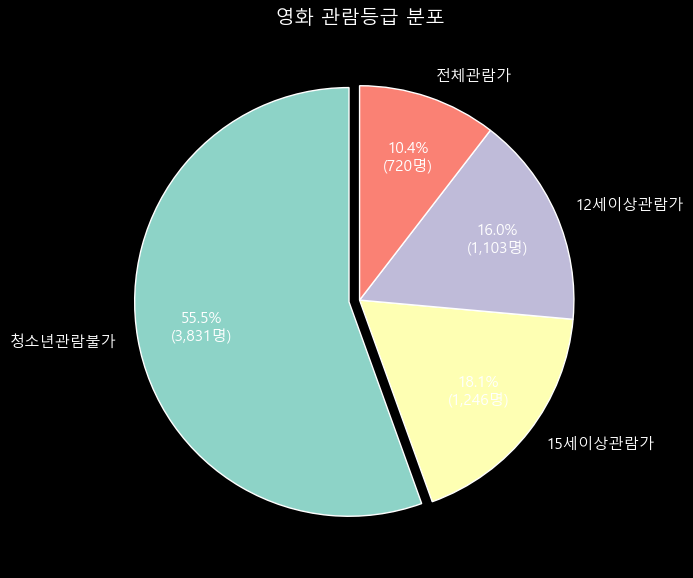

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# 관람등급 카운트
rating_counts = result_df['GRAD_NM'].value_counts()

labels = rating_counts.index
sizes = rating_counts.values

# explode (가장 비중 큰 등급 강조)
explode = [0.05 if i == 0 else 0 for i in range(len(sizes))]

# 퍼센트 + 실제 수치 함께 표시 함수
def autopct_format(pct):
    absolute = int(pct/100.*np.sum(sizes))
    return f'{pct:.1f}%\n({absolute:,}명)'

plt.figure(figsize=(7,7))

wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    explode=explode,
    autopct=autopct_format,
    startangle=90,
    pctdistance=0.7,        # 퍼센트 위치 조정
    labeldistance=1.1,      # 바깥 라벨 위치 조정
    textprops={'fontsize': 11},
    wedgeprops={'edgecolor': 'white'}
)

plt.title("영화 관람등급 분포", fontsize=14)
plt.tight_layout()
plt.show()

## 2. VIEWNG
## 2.1 영화 전체 산점도

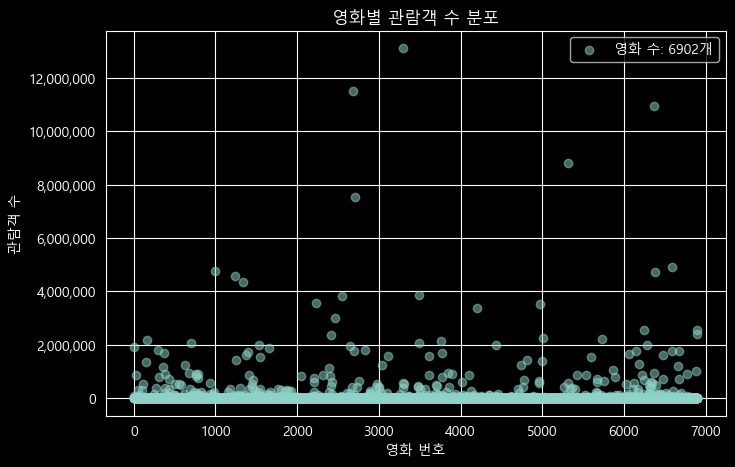

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

plt.figure(figsize=(8,5))
num_points = len(result_df)

plt.scatter(
    np.arange(len(result_df)),        # 영화 개수만큼 0,1,2,... 자동 생성
    result_df['VIEWNG_NMPR_CO'],
    alpha=0.5,
    label=f"영화 수: {num_points}개"
)

plt.xlabel("영화 번호")  # x축 이름 제거
plt.ylabel("관람객 수")
plt.title("영화별 관람객 수 분포")

# 지수표기 제거
plt.ticklabel_format(style='plain', axis='y')

# 천 단위 콤마 표시
plt.gca().yaxis.set_major_formatter(
    ticker.StrMethodFormatter('{x:,.0f}')
)

plt.legend()
plt.show()

## 2.2 총 관람객 1만명 이상 산점도

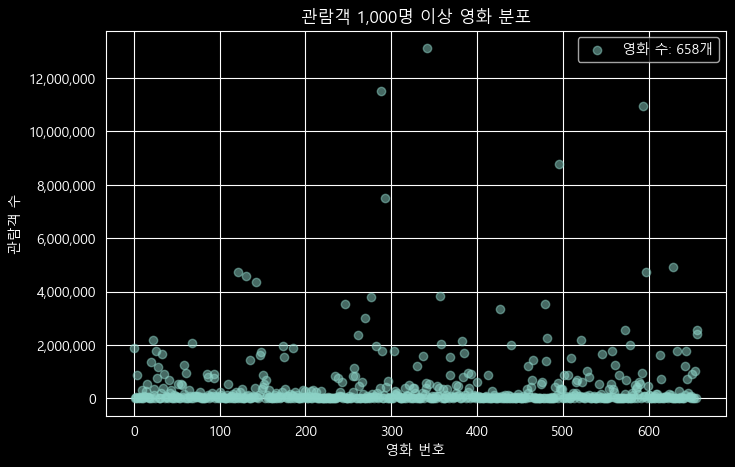

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# 관객수 1000명 이상만 필터링
filtered_df = result_df[result_df['VIEWNG_NMPR_CO'] >= 10000]

# 점 개수 계산
num_points = len(filtered_df)

plt.figure(figsize=(8,5))

plt.scatter(
    np.arange(num_points),
    filtered_df['VIEWNG_NMPR_CO'],
    alpha=0.5,
    label=f"영화 수: {num_points}개"
)

plt.xlabel("영화 번호")
plt.ylabel("관람객 수")
plt.title("관람객 1,000명 이상 영화 분포")

# 지수표기 제거
plt.ticklabel_format(style='plain', axis='y')

# 천 단위 콤마 표시
plt.gca().yaxis.set_major_formatter(
    ticker.StrMethodFormatter('{x:,.0f}')
)

plt.legend()
plt.show()

## 2.3 총 관람객 10만명 이상 산점도

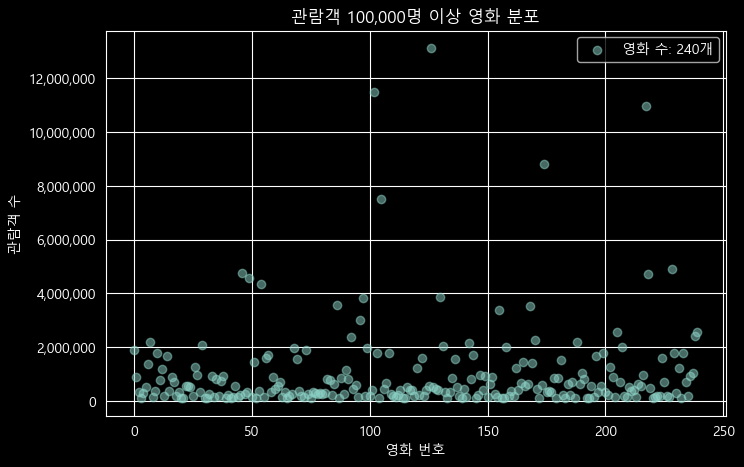

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# 관객수 1000명 이상만 필터링
filtered_df = result_df[result_df['VIEWNG_NMPR_CO'] >= 100000]

# 점 개수 계산
num_points = len(filtered_df)

plt.figure(figsize=(8,5))

plt.scatter(
    np.arange(num_points),
    filtered_df['VIEWNG_NMPR_CO'],
    alpha=0.5,
    label=f"영화 수: {num_points}개"
)

plt.xlabel("영화 번호")
plt.ylabel("관람객 수")
plt.title("관람객 100,000명 이상 영화 분포")

# 지수표기 제거
plt.ticklabel_format(style='plain', axis='y')

# 천 단위 콤마 표시
plt.gca().yaxis.set_major_formatter(
    ticker.StrMethodFormatter('{x:,.0f}')
)

plt.legend()
plt.show()

## 2.4 관람 등급별 관객수 누적분포 비교

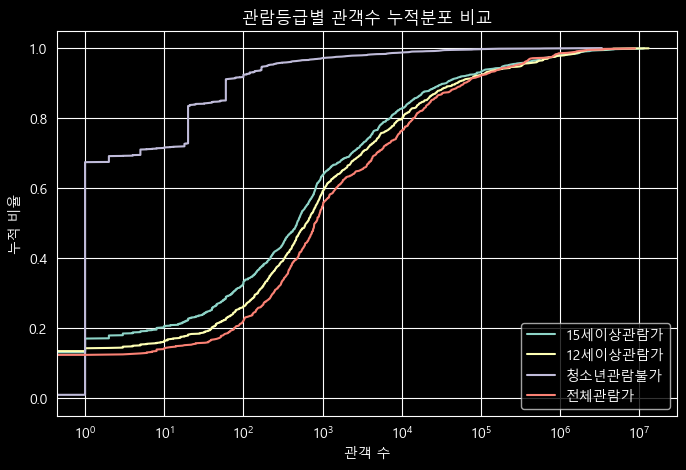

In [57]:
plt.figure(figsize=(8,5))

for grade in result_df['GRAD_NM'].unique():
    subset = result_df[result_df['GRAD_NM'] == grade]
    sorted_vals = np.sort(subset['VIEWNG_NMPR_CO'])
    yvals = np.arange(len(sorted_vals)) / float(len(sorted_vals))
    plt.plot(sorted_vals, yvals, label=grade)

plt.xscale("log")
plt.xlabel("관객 수")
plt.ylabel("누적 비율")
plt.title("관람등급별 관객수 누적분포 비교")
plt.legend()
plt.show()

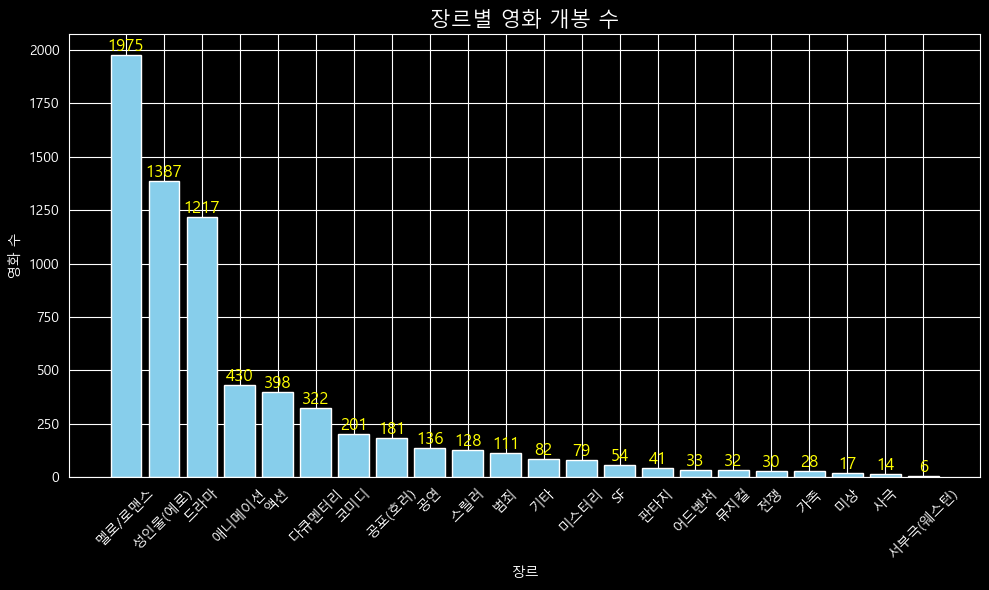

In [65]:
data = result_df['GENRE_NM'].value_counts() # 장르별 개수 카운트

# 그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.bar(data.index, data.values, color='skyblue')

# 그래프 꾸미기
plt.title('장르별 영화 개봉 수', fontsize=15)
plt.xlabel('장르')
plt.ylabel('영화 수')
plt.xticks(rotation=45) # 장르 이름이 길면 겹치니까 회전!

# 바 위에 숫자 표시 (첫 번째 이미지에서 썼던 방식이야)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', color='yellow', fontsize=12)

plt.tight_layout()
plt.show()

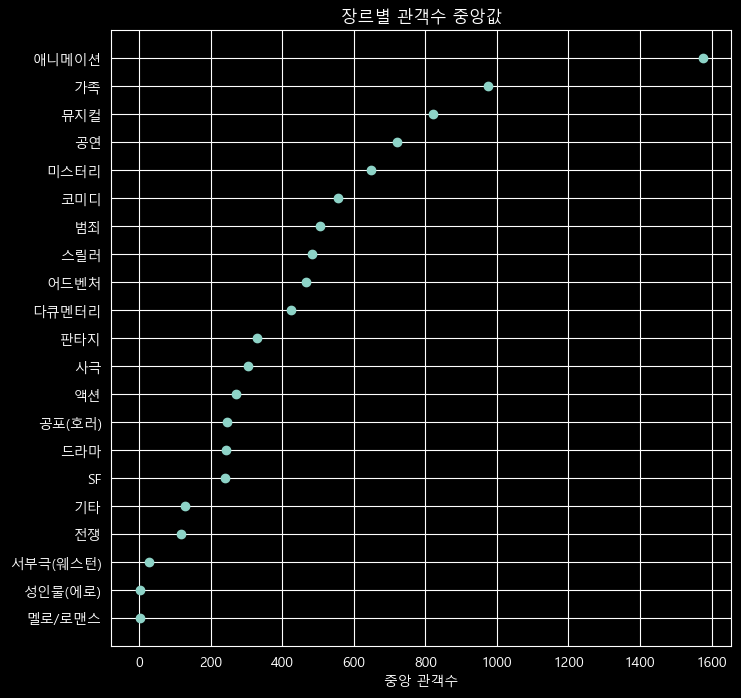

In [63]:
genre_stats = (
    movie_df
    .groupby('GENRE_NM')['VIEWNG_NMPR_CO']
    .median()
    .sort_values()
)

plt.figure(figsize=(8,8))

plt.scatter(
    genre_stats.values,
    genre_stats.index
)

plt.title("장르별 관객수 중앙값")
plt.xlabel("관객수 중앙값")
plt.show()